In [3]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.stats import mode

In [17]:
import sys
sys.path.insert(0, '../')

In [18]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from features import process_eeg
from config.constants import *
from viz.plot import *
from features import statistical_features

In [20]:
filename = "train_non_overlap.csv"
file_path = os.path.join(PROCESSED_DATA_DIR, filename)
TRAIN_RAW_DF = os.path.join(RAW_DATA_DIR, "train.csv")
df_raw =  pd.read_csv(TRAIN_RAW_DF)


df = pd.read_csv(file_path)
print(df_raw.shape)
df_raw.head()

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


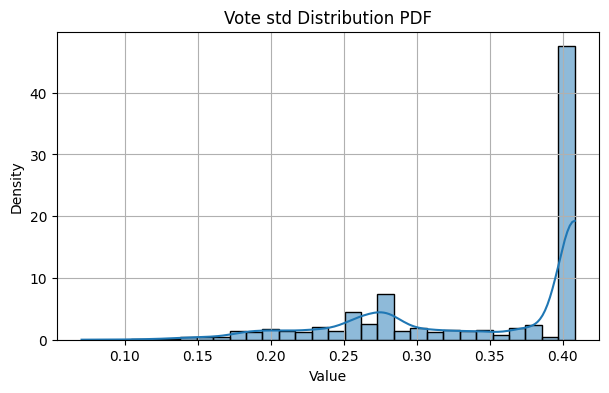

mode value 0.408248290463863
mode count 9120


In [21]:
std_values = df.iloc[:, -7:-1].std(axis=1)

plot_pdf(std_values, bins=30, title='Vote std Distribution PDF', xlabel='Value', ylabel='Density')

mode_value, mode_count = mode(std_values)
print("mode value",mode_value)
print("mode count",mode_count)


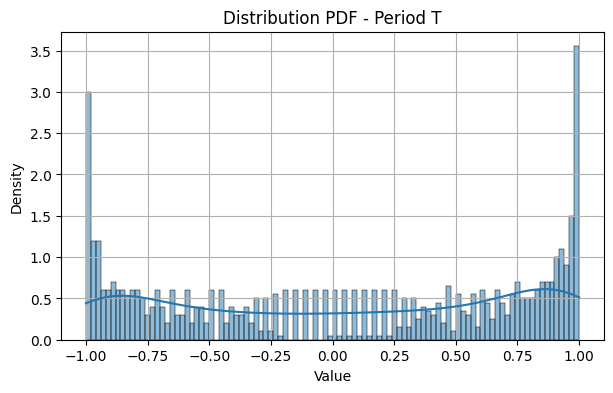

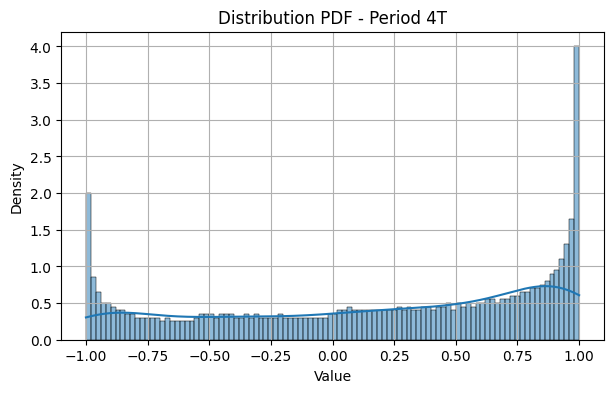

In [22]:
#Toy Sample, visualizating the pdfs for different hz waves
T = 2 * np.pi
amplitude = 1 

x = np.linspace(0, 40 * T, 1000)  
sin_T = amplitude * np.sin(x / T)
sin_4T = amplitude * np.sin(x / (4 * T))

plot_pdf(sin_T, bins=100, title='Distribution PDF - Period T', xlabel='Value', ylabel='Density')
plot_pdf(sin_4T, bins=100, title='Distribution PDF - Period 4T', xlabel='Value', ylabel='Density')

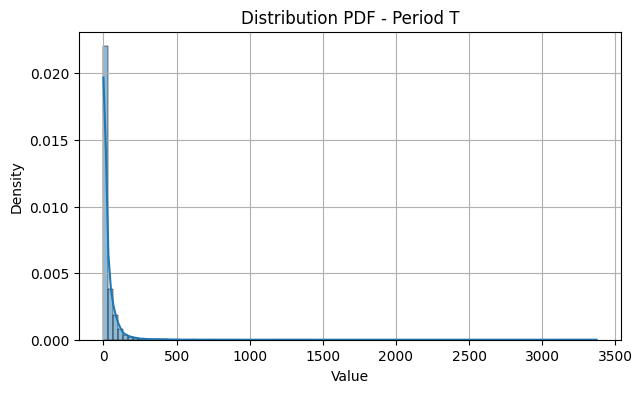

The max window size eeg samples covers:  3372.0


In [23]:
diffs = df_raw.groupby('eeg_id')['eeg_label_offset_seconds'].agg(lambda x: x.max() - x.min())
diffs_array = diffs.to_numpy()
plot_pdf(diffs_array, bins=100, title='Distribution PDF - Period T', xlabel='Value', ylabel='Density')
print("The max window size eeg samples covers: " , np.max(diffs_array))


In [24]:
def filter_samples(group):
    '''For each unique eeg sample, collect non-overlapping 50-sec samples '''
    
    selected_indices = []
    
    current_interval_start = group.iloc[0]
    for i, time in enumerate(group):
        
        if time >= current_interval_start:
           
            selected_indices.append(i)
            current_interval_start = time + 30 #end of 10 sec window

    return group.iloc[selected_indices]

filtered_samples = df_raw.groupby('eeg_id')['eeg_label_offset_seconds'].apply(filter_samples).reset_index()
print(f"There are {len(filtered_samples)} non-overlapping samples that contains different middle 10-sec windows")
print(f"filtered_samples shape: {filtered_samples.shape}")
filtered_samples.head()

There are 28387 non-overlapping samples that contains different middle 10-sec windows
filtered_samples shape: (28387, 3)


,eeg_id,level_1,eeg_label_offset_seconds
0,568657,40927,0.0
1,582999,77116,0.0
2,582999,77126,38.0
3,642382,1149,0.0
4,751790,31929,0.0


In [25]:
#filtered_samples['eeg_id'] = filtered_samples['eeg_id'].astype('int64')
####
df_raw =  pd.read_csv(TRAIN_RAW_DF)
print(df_raw[df_raw['eeg_id'] < 0]['eeg_id'].unique())
####
filtered_df = pd.merge(df_raw, filtered_samples, on=['eeg_id', 'eeg_label_offset_seconds'])
print(filtered_df.shape)
filtered_df.head()

[]
(28387, 16)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,level_1
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,0
1,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0,6
2,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5,9
3,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0,1,0,14,0,1,11
4,387987538,0,0.0,1084844,0,0.0,4099147263,4264,LRDA,0,0,0,3,0,0,22


In [26]:
# votes to probs
vote_columns = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

total_votes = filtered_df[vote_columns].sum(axis=1)

#total_votes = total_votes.replace(0, 1)

filtered_df[vote_columns] = filtered_df[vote_columns].div(total_votes, axis=0)

filtered_df.head()


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,level_1
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,0
1,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,1.0,0.0000,0.000000,0.000,0.000000,0.000000,6
2,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0.0,0.0000,0.454545,0.000,0.090909,0.454545,9
3,722738444,0,0.0,999431,0,0.0,557980729,56885,LRDA,0.0,0.0625,0.000000,0.875,0.000000,0.062500,11
4,387987538,0,0.0,1084844,0,0.0,4099147263,4264,LRDA,0.0,0.0000,0.000000,1.000,0.000000,0.000000,22


In [27]:
file_path = f"{PROCESSED_DATA_DIR}/filtered_df_probabilities.csv"
filtered_df.to_csv(file_path, index=False)
print(f"File saved to {file_path}")

File saved to D:\Kaggle_Contest_Record\HMS_Harmful Brain Activity Classification/data/processed/filtered_df_probabilities.csv
